In [129]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F

In [130]:
# Importing training features and labels
train_x = np.load('/content/drive/MyDrive/x_train.npy')
train_y = np.load('/content/drive/MyDrive/y_train.npy')

In [131]:
# Custom Loader Class
class CustomDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        sample = self.features[idx], self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

class ReshapeTransform:
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        features, labels = sample
        features = features.view(self.output_size)
        return features, labels

class CustomDataLoader:
    def __init__(self, features, labels, batch_size=32, validation_size=0.2, seed=None):
        # Transform to 28x28
        transform = transforms.Compose([ReshapeTransform((1, 28, 28))])
        dataset = CustomDataset(features, labels, transform=transform)
        # Validation data with respect to the split percentage
        validation_split_index = int(len(dataset) * validation_size)
        if seed is not None:
            torch.manual_seed(seed)
        # Randomly split dataset to get training and validation dataset
        train_dataset, val_dataset = random_split(dataset, [len(dataset) - validation_split_index, validation_split_index])
        # Use PyTorch DataLoader method to split dataset into batches
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    def get_train_loader(self):
        return self.train_loader

    def get_val_loader(self):
        return self.val_loader


In [132]:
data_loader = CustomDataLoader(train_x, train_y, batch_size=64, validation_size=0.2, seed=42)
# Get training and validation loaders
x_train = data_loader.get_train_loader()
x_val = data_loader.get_val_loader()

In [134]:
# Dictionary to store features for each unique digits
digits = {}
# Counter to keep track of unique digits
digit_count = 0

# Iterate through the training set
for features, labels in x_train:
    # Iterate through batch
    for feature, label in zip(features, labels):
        label = label.item()
        # Check if didgits exists in the map
        if label not in digits:
            digit_count += 1
            # Break the loop if 10 unique labels are encountered
            if digit_count > 10:
                break
            digits[label] = []
        # Append features to corresponding label
        digits[label].append(feature)
# Iterate through validation set
for features, labels in x_val:
  for feature, label in zip(features, labels):
        label = label.item()
        # Check if didgits exists in the map
        if label not in digits:
            digit_count += 1
            # Break the loop if 10 unique labels are encountered
            if digit_count > 10:
                break
            digits[label] = []
        # Append features to corresponding label
        digits[label].append(feature)

# Print digits and number of samples for each digit
for label, feature_list in digits.items():
    print(f"Label {label}: {len(feature_list)} samples")

Label 3.0: 6131 samples
Label 1.0: 6742 samples
Label 7.0: 6265 samples
Label 8.0: 5851 samples
Label 6.0: 5918 samples
Label 9.0: 5949 samples
Label 2.0: 5958 samples
Label 5.0: 5421 samples
Label 0.0: 5923 samples
Label 4.0: 5842 samples


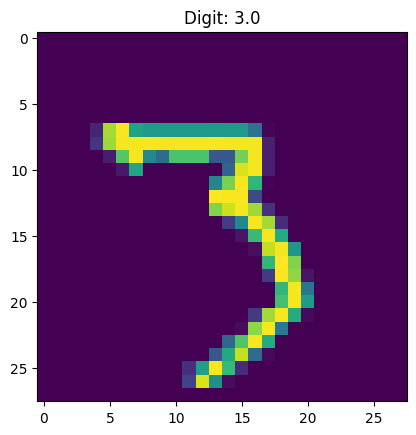

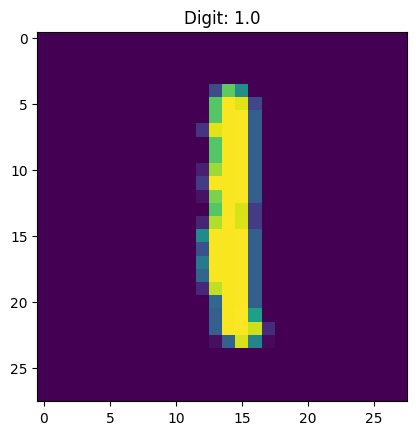

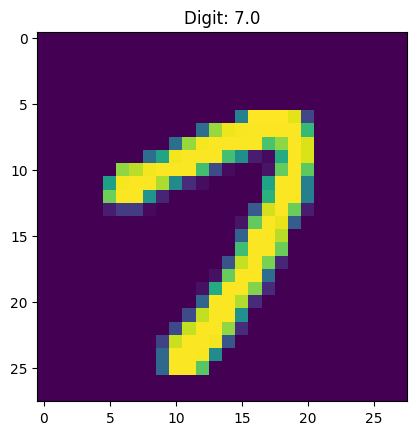

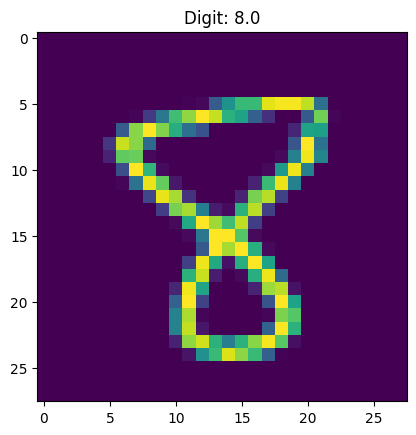

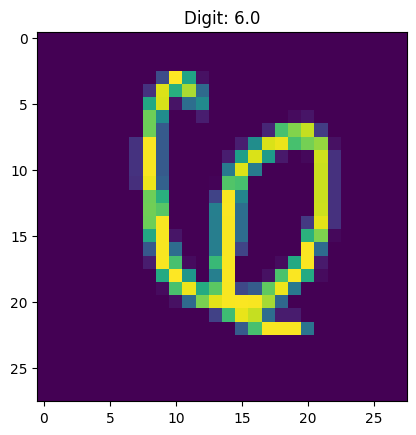

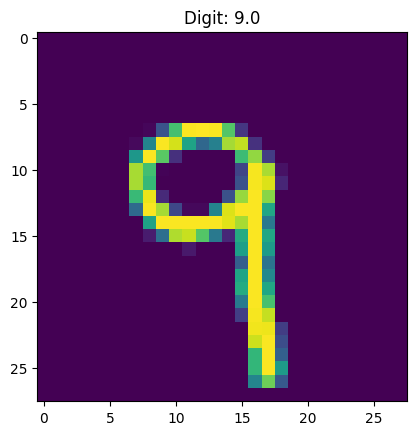

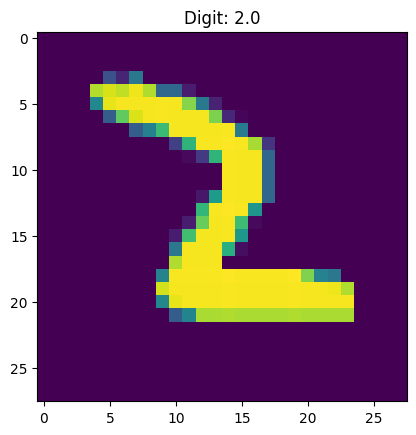

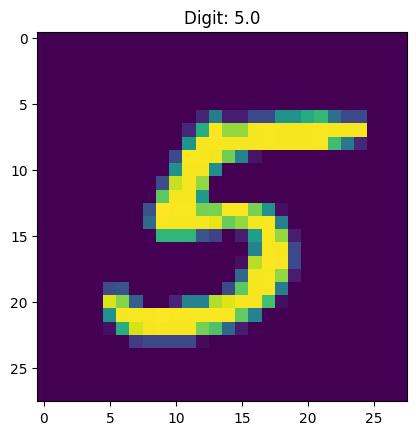

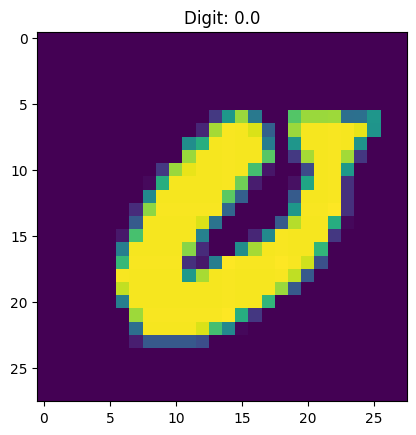

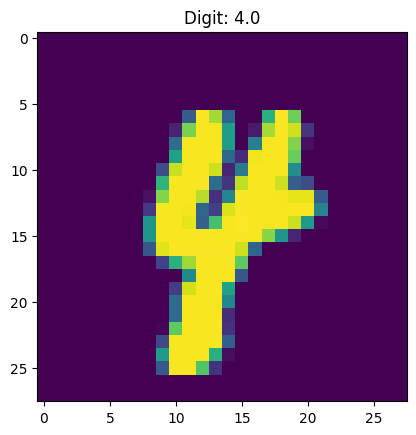

In [135]:
# Print one sample of each digit
for d in digits:
  feature = digits[d][0][0]
  label = d
  feature_value = feature.numpy()
  plt.imshow(feature_value)
  plt.title(f'Digit: {label}')
  plt.show()

In [125]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_conv_layers=2, filter_size=3, dropout_rate=0.5):
      #Initialize the model from the library
      super(CNN, self).__init__()
      self.num_conv_layers = num_conv_layers

      # Defiles layers of convolutional layers, activation function, pooling
      self.conv_layers = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=32, kernel_size=filter_size, padding=filter_size // 2), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2)])

      for _ in range(num_conv_layers - 1):
        self.conv_layers.extend([nn.Conv2d(in_channels=32, out_channels=64, kernel_size=filter_size, padding=filter_size // 2), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2)])

      self.fc_layers = nn.Sequential(nn.Linear(64 * 7 * 7, 128), nn.ReLU(inplace=True), nn.Dropout(dropout_rate), nn.Linear(128, 10))

    # Defines forward pass of neural network
    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [136]:
class CNN(nn.Module):
    def __init__(self, num_conv_layers=2, filter_size=3, dropout_rate=0.5):
        super(CNN, self).__init__()
        self.num_conv_layers = num_conv_layers

        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=filter_size, padding=filter_size // 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        ])

        for _ in range(num_conv_layers - 1):
            self.conv_layers.extend([
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=filter_size, padding=filter_size // 2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2)
            ])

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [ ]:
# List of input parameters
num_conv_layers_list = [2]
filter_size_list = [3, 5, 7]
dropout_rate_list = [0.3, 0.5, 0.7]
accuracies = {}

# Evaluation Function
def train_and_evaluate_model(num_conv_layers, filter_size, dropout_rate):
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
  # Model initialization
  model = CNN(num_conv_layers=num_conv_layers, filter_size=filter_size, dropout_rate=dropout_rate)
  # Use Cross Entropy as loss function
  criterion = nn.CrossEntropyLoss()
  # Optimization algorithm to update parameters
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  num_epochs = 5
  epoch_loss = 0.0

  # Calculating the loss values
  for epoch in range(num_epochs):
    model.train()
    for inputs, labels in x_train:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels.long())
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

  # Evaluating the model
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in x_val:
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = correct / total
  return accuracy

for num_conv_layers in num_conv_layers_list:
    for filter_size in filter_size_list:
        for dropout_rate in dropout_rate_list:
            accuracy = train_and_evaluate_model(num_conv_layers, filter_size, dropout_rate)
            accuracies[(num_conv_layers, filter_size, dropout_rate)] = accuracy

In [156]:
best_acc = 0

for param in accuracies:
  if accuracies[param]>best_acc:
    best_param = param
    best_acc = accuracies[param]

print('Best Accuracy acheived:', best_acc, 'Number of Layers:', best_param[0], 'Filter Size:', best_param[1], 'dropout:', best_param[2])

Best Accuracy acheived: 0.9920833333333333 Number of Layers: 2 Filter Size: 5 dropout: 0.5


In [157]:
test_x = np.load('/content/drive/MyDrive/x_test.npy')

In [161]:
test_data_tensor = torch.tensor(test_x, dtype=torch.float32)
resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])
test_data_resized = torch.stack([resize_transform(test_data_tensor[i]) for i in range(len(test_data_tensor))])
test_dataset = TensorDataset(test_data_resized)
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [162]:
def generate_test_labels(model, test_loader):
    model.eval()
    test_labels = []
    with torch.no_grad():
        for inputs in test_loader:
            outputs = model(inputs[0])
            _, predicted = torch.max(outputs, 1)
            test_labels.extend(predicted.tolist())
    return test_labels


In [163]:
best_model = CNN(num_conv_layers=best_param[0], filter_size=best_param[1], dropout_rate=best_param[2])
test_labels = generate_test_labels(best_model, x_train)

In [165]:
# Add the 2 predicted outputs to CSV
import csv

data = zip(test_labels)

csv_filename = '/content/drive/MyDrive/Pavan Santosh_Nippani Ravi_preds.csv'

fieldnames = ['pred_cnn']

# Write data to CSV file
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    writer.writeheader()

    for row in data:
        writer.writerow({fieldnames[0]: row[0]})

print(f"CSV file '{csv_filename}' has been created successfully.")

CSV file '/content/drive/MyDrive/Pavan Santosh_Nippani Ravi_preds.csv' has been created successfully.
